In [145]:
import gf
from bch import BCH

import numpy as np
from time import time
import matplotlib.pyplot as plt

В качестве примера кода бчх, истинное расстояние которого больше, чем 2 * t + 1, можно привести вырожденный случай, когда размер k каждого блока передаваемого сообщения составляет 1 бит, и этот бит просто дублируется нужное количество раз.

In [31]:
curr_bch = BCH(7, 2)
curr_bch.deg_g

6

Степень порождающего полинома равна 6, следовательно, k = n - deg_g = 7 - 6 = 1. Попробуем закодировать сообщения и убедимся, что все соответствует описанию выше.

In [35]:
curr_bch.encode(np.array([[1], [0]]))

array([[1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0]])

Теперь протестируем работу разных реализаций декодера.

In [143]:
n = 1023
num_samples = 500
t = 5
correct_list_eucl = []
err_list_eucl = []
nan_list_eucl = []

correct_list_pgz = []
err_list_pgz = []
nan_list_pgz = []

for err_num in range(1, 10):
    curr_bch = BCH(n, t)
    U = np.random.randint(0, 2, (num_samples, n - curr_bch.deg_g))
    encoded = curr_bch.encode(U)
    W = encoded.copy()
    for i in range(num_samples):
        err_indexes = np.random.choice(n, err_num, replace=False)
        W[i, err_indexes] = np.logical_not(W[i, err_indexes])
        
    decoded_eucl = curr_bch.decode(W, method='euclid')
    nan_list_eucl.append(np.sum(decoded_eucl[:, 0] < 0))
    nan_mask = decoded_eucl[:, 0] >= 0
    num_correct = np.logical_xor(decoded_eucl[nan_mask, :], encoded[nan_mask, :])
    num_correct = np.sum(np.logical_not(np.sum(num_correct, axis=1)))
    correct_list_eucl.append(num_correct)
    err_list_eucl.append(num_samples - nan_list_eucl[-1] - correct_list_eucl[-1])
    
    decoded_pgz = curr_bch.decode(W, method='pgz')
    nan_list_pgz.append(np.sum(decoded_pgz[:, 0] < 0))
    nan_mask = decoded_pgz[:, 0] >= 0
    num_correct = np.logical_xor(decoded_pgz[nan_mask, :], encoded[nan_mask, :])
    num_correct = np.sum(np.logical_not(np.sum(num_correct, axis=1)))
    correct_list_pgz.append(num_correct)
    err_list_pgz.append(num_samples - nan_list_pgz[-1] - correct_list_pgz[-1])

Text(0, 0.5, 'proportion of result')

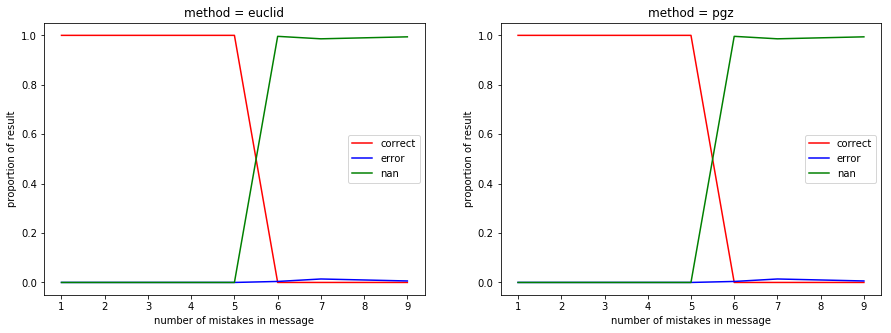

In [171]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(range(1, 10), [x / num_samples for x in correct_list_eucl], label='correct', c='r')
ax[0].plot(range(1, 10), [x / num_samples for x in err_list_eucl], label='error', c='b')
ax[0].plot(range(1, 10), [x / num_samples for x in nan_list_eucl], label='nan', c='g')
ax[0].legend()
ax[0].set_title('method = euclid')
ax[0].set_xlabel('number of mistakes in message')
ax[0].set_ylabel('proportion of result')

ax[1].plot(range(1, 10), [x / num_samples for x in correct_list_pgz], label='correct', c='r')
ax[1].plot(range(1, 10), [x / num_samples for x in err_list_pgz], label='error', c='b')
ax[1].plot(range(1, 10), [x / num_samples for x in nan_list_pgz], label='nan', c='g')
ax[1].legend()
ax[1].set_title('method = pgz')
ax[1].set_xlabel('number of mistakes in message')
ax[1].set_ylabel('proportion of result')

Как и ожидалось, на результат декодирования используемый метод не влияет. Эксперимент проводился с кодом, исправляющим 5 ошибок. Как видно на графиках, код действительно показывает 100% точность исправления при числе ошибок при передаче сообщения, меньшем либо равном пяти. При дальнейшем увеличении числа ошибок число корректно исправленных сообщений падает до нуля, и близким к нулю становится число отказов от декодирования. Это поведение является корректным для алгоритма. Число ошибок незначительно.

Проведем эксперимент для сравнения времени работы двух алгоритмов декодирования.

Число ошибок, которое код может исправить.

In [200]:
t = 3
num_samples = 10
err_num = 3
eucl_list = []
pgz_list = []

for q in range(2, 15):
    n = 2 ** q - 1
    curr_bch = BCH(n, t)
    U = np.random.randint(0, 2, (num_samples, n - curr_bch.deg_g))
    encoded = curr_bch.encode(U)
    W = encoded.copy()
    for i in range(num_samples):
        err_indexes = np.random.choice(n, err_num, replace=False)
        W[i, err_indexes] = np.logical_not(W[i, err_indexes])
    
    start = time()
    decoded_eucl = curr_bch.decode(W, method='euclid')
    end = time()
    eucl_list.append((end - start) / num_samples)
    
    start = time()
    decoded_pgz = curr_bch.decode(W, method='pgz')
    end = time()
    pgz_list.append((end - start) / num_samples)

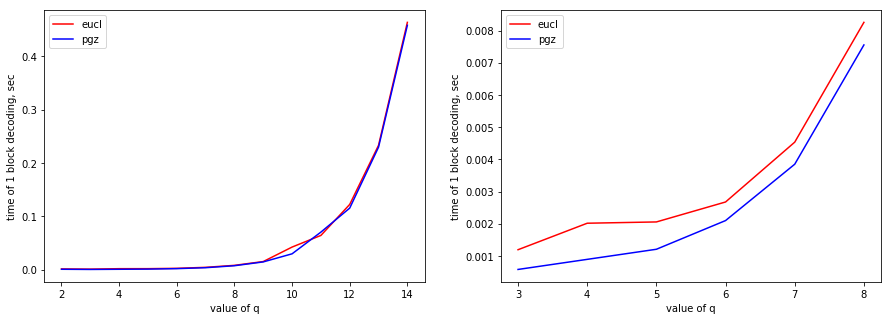

In [209]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(2, 15), eucl_list, label='eucl', c='r')
ax[0].plot(range(2, 15), pgz_list, label='pgz', c='b')
ax[0].legend()
ax[0].set_xlabel('value of q')
ax[0].set_ylabel('time of 1 block decoding, sec')

ax[1].plot(range(3, 9), eucl_list[1:7], label='eucl', c='r')
ax[1].plot(range(3, 9), pgz_list[1:7], label='pgz', c='b')
ax[1].legend()
ax[1].set_xlabel('value of q')
ax[1].set_ylabel('time of 1 block decoding, sec')
ax[1].set_xticks(range(3, 9))


plt.show()

При небольших значениях n pgz работает значительно быстрее, с ростом n время работы методов различается все меньше.

Число ошибок, превышающее количество, которое может исправить код.

In [210]:
t = 3
num_samples = 10
err_num = 4
eucl_list = []
pgz_list = []

for q in range(3, 15):
    n = 2 ** q - 1
    curr_bch = BCH(n, t)
    U = np.random.randint(0, 2, (num_samples, n - curr_bch.deg_g))
    encoded = curr_bch.encode(U)
    W = encoded.copy()
    for i in range(num_samples):
        err_indexes = np.random.choice(n, err_num, replace=False)
        W[i, err_indexes] = np.logical_not(W[i, err_indexes])
    
    start = time()
    decoded_eucl = curr_bch.decode(W, method='euclid')
    end = time()
    eucl_list.append((end - start) / 10)
    
    start = time()
    decoded_pgz = curr_bch.decode(W, method='pgz')
    end = time()
    pgz_list.append((end - start) / 10)

Text(0, 0.5, 'time of 1 block decoding, sec')

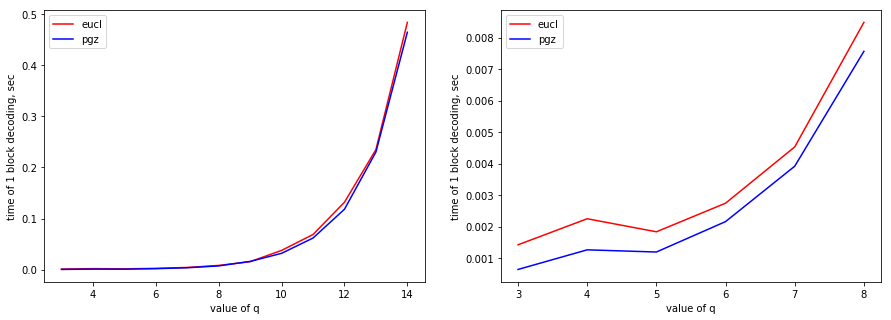

In [211]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(range(3, 15), eucl_list, label='eucl', c='r')
ax[0].plot(range(3, 15), pgz_list, label='pgz', c='b')
ax[0].legend()
ax[0].set_xlabel('value of q')
ax[0].set_ylabel('time of 1 block decoding, sec')

ax[1].plot(range(3, 9), eucl_list[:6], label='eucl', c='r')
ax[1].plot(range(3, 9), pgz_list[:6], label='pgz', c='b')
ax[1].legend()
ax[1].set_xlabel('value of q')
ax[1].set_ylabel('time of 1 block decoding, sec')

Все наблюдаемые зависимости аналогичны предыдущему эксперименту.